# Lab 6: Essay Writer

## セットアップとインポート

このセクションでは、より複雑なプロジェクトを構築します：AIエッセイライターです。まず環境をセットアップし、必要なライブラリをインポートします。Amazon BedrockとAnthropicのClaudeモデルを使用するため、インポートはそれを反映しています。

ログを設定し、Bedrockを構成し、Tavily APIキーを取得します。Tavilyはエッセイの情報収集に使用する研究ツールです。Tavily APIキーが安全に保存されていることを確認してください。

最後に構築するUIの要件：

1. `.env`ファイルにtavily aiキーを追加してください。
2. LangGraph 0.0.53で実行していることに注意してください。
3. CLIからhelper.pyを実行し、Webブラウザを開いてグラフをステップ実行するか、ノートブックで直接実行してください！

In [31]:
from dotenv import load_dotenv
import json
import os
import re
import sys
import warnings
import boto3
from botocore.config import Config
warnings.filterwarnings("ignore")
import logging

# ローカルモジュールのインポート
dir_current = os.path.abspath("")
dir_parent = os.path.dirname(dir_current)
if dir_parent not in sys.path:
    sys.path.append(dir_parent)
from utils import utils

# 基本設定
logger = utils.set_logger()  # ロガーの設定
pp = utils.set_pretty_printer()  # 整形出力用のプリンターを設定

# .envファイルまたはSecret Managerから環境変数を読み込む
_ = load_dotenv("../.env")
aws_region = os.getenv("AWS_REGION")  # AWS地域を環境変数から取得
tavily_ai_api_key = utils.get_tavily_api("TAVILY_API_KEY", aws_region)  # Tavily APIキーを取得

# Bedrockの設定
bedrock_config = Config(connect_timeout=120, read_timeout=120, retries={"max_attempts": 0})  # タイムアウトと再試行の設定

# Bedrockランタイムクライアントの作成
bedrock_rt = boto3.client("bedrock-runtime", region_name=aws_region, config=bedrock_config)

# 利用可能なモデルを確認するためのBedrockクライアントの作成
bedrock = boto3.client("bedrock", region_name=aws_region, config=bedrock_config)

[2025-07-10 05:58:21,466] p3211361 {utils.py:66} INFO - TAVILY_API_KEY variable correctly retrieved from the .env file.
[2025-07-10 05:58:21,602] p3211361 {utils.py:66} INFO - TAVILY_API_KEY variable correctly retrieved from the .env file.


## エージェント状態の定義

次に、エージェントの状態を定義しましょう。これは以前のレッスンよりも複雑です。なぜなら、エッセイライターには複数のステップがあり、さまざまな情報を追跡する必要があるからです。

AgentStateというTypedDictを作成しています。これには以下が含まれます：

- task: エッセイのトピックまたは質問
- plan: エッセイのアウトライン
- draft: エッセイの現在のバージョン
- critique: 現在の下書きに対するフィードバック
- content: Tavilyからの研究情報
- revision_number: 何回修正を行ったか
- max_revisions: 行いたい最大修正回数

これらの要素は、エッセイ執筆プロセスを管理し、いつ修正を停止するかを知るのに役立ちます。

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.messages import (
    AnyMessage,
    SystemMessage,
    HumanMessage,
    AIMessage,
    ChatMessage,
)

memory = MemorySaver()

In [3]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

## モデルのセットアップ

Amazon Bedrock経由でAnthropicのClaudeモデルを使用しています。より一貫した出力を得るために、温度を0に設定してセットアップしています。使用しているモデルはclaude-3-haikuで、このタスクに適しています。

In [4]:
from langchain_aws import ChatBedrockConverse

model = ChatBedrockConverse(
    client=bedrock_rt,
    model="us.anthropic.claude-3-5-haiku-20241022-v1:0",
    temperature=0,
    max_tokens=None,
)

## プロンプトの定義

エッセイライターは、プロセスの異なる段階で複数のプロンプトを使用します：

1. **PLAN_PROMPT**: モデルにエッセイのアウトラインを作成するよう指示します。
2. **WRITER_PROMPT**: 計画と研究に基づいてエッセイを書くようモデルを導きます。
3. **REFLECTION_PROMPT**: エッセイを批評する方法をモデルに伝えます。
4. **RESEARCH_PLAN_PROMPT**と**RESEARCH_CRITIQUE_PROMPT**: 研究ステップの検索クエリ生成を支援します。

各プロンプトは、エッセイ執筆プロセス内でモデルが特定のタスクを実行するよう導くために慎重に作成されています。

In [5]:
PLAN_PROMPT = """あなたはエッセイの高レベルなアウトラインを書くことを任された専門ライターです。\
ユーザーが提供したトピックについて、そのようなアウトラインを書いてください。エッセイのアウトラインと、\
セクションに関連するメモや指示を提供してください。"""

In [6]:
WRITER_PROMPT = """あなたは優秀な5段落エッセイを書くことを任されたエッセイアシスタントです。\
ユーザーのリクエストと初期アウトラインに対して可能な限り最高のエッセイを生成してください。\
ユーザーが批評を提供した場合は、以前の試みの修正版で応答してください。\
必要に応じて以下のすべての情報を活用してください：

------

<content>{content}</content>"""

In [7]:
REFLECTION_PROMPT = """あなたはエッセイの提出物を採点する教師です。\
ユーザーの提出物に対する批評と推奨事項を生成してください。\
長さ、深さ、スタイルなどの要求を含む詳細な推奨事項を提供してください。"""

In [8]:
RESEARCH_PLAN_PROMPT = """あなたは以下のエッセイを書く際に使用できる情報を提供することを任された研究者です。\
関連する情報を収集する検索クエリのリストを生成してください。最大3つのクエリのみを生成してください。"""

In [9]:
RESEARCH_CRITIQUE_PROMPT = """あなたは（以下に概説されている）要求された修正を行う際に使用できる情報を提供することを任された研究者です。\
関連する情報を収集する検索クエリのリストを生成してください。最大3つのクエリのみを生成してください。"""

Kiro
### Anthropicモデルでの構造化出力生成に関する補足：

上記のプロンプトを見てください。
- これらはAnthropicのプロンプティングガイドに従っていますか？
- 例えば、REFLECTION_PROMPTに対して以下のような回答構造を要求することで、より一貫した出力を得られると思いますか？

```xml
<answer>
  <overall_assessment>
    <strengths>
      <strength_point></strength_point>
      <strength_point></strength_point>
    </strengths>
    <weaknesses>
      <weakness_point></weakness_point>
      <weakness_point></weakness_point>
    </weaknesses>
  </overall_assessment>

...

  <style_and_language>
    <clarity>
      <comment></comment>
      <recommendation></recommendation>
    </clarity>
    <tone>
      <comment></comment>
      <recommendation></recommendation>
    </tone>
    <grammar_and_mechanics>
      <comment></comment>
      <recommendation></recommendation>
    </grammar_and_mechanics>
  </style_and_language>

  <length_assessment>
    <comment></comment>
    <recommendation></recommendation>
  </length_assessment>

  <conclusion>
    <overall_recommendation></overall_recommendation>
    <priority_improvements>
      <improvement></improvement>
      <improvement></improvement>
    </priority_improvements>
  </conclusion>
</answer>
```

- このような構造の利点と欠点は何でしょうか？
- 追加のトークンは価値があるかを自問してください。詳細でトークン集約的なプロンプトに投資すべき場合と、より自由形式のプロンプトを使うべき場合はいつでしょうか？
- この出力をどのように解析しますか？

ヒント： LangChainのXMLOutput-ParserとPyDanticモデルを組み合わせることができます。 参考として、以下では.with_structured_output(...)のような方法に依存せずにXMLOutputパーサーを使用する方法を示します。これはlangchainの非常に最近の追加機能です。- 

In [10]:
import re

# 簡易的なXML解析関数
def parse_xml(xml_string):
    # 簡易的な解析を行い、辞書形式で返す
    result = {}
    
    # 強みの抽出
    strength_pattern = r"<strength_point>(.*?)</strength_point>"
    strengths = re.findall(strength_pattern, xml_string, re.DOTALL)
    
    # 弱みの抽出
    weakness_pattern = r"<weakness_point>(.*?)</weakness_point>"
    weaknesses = re.findall(weakness_pattern, xml_string, re.DOTALL)
    
    # コメントと推奨事項の抽出
    comment_pattern = r"<comment>(.*?)</comment>"
    comments = re.findall(comment_pattern, xml_string, re.DOTALL)
    
    recommendation_pattern = r"<recommendation>(.*?)</recommendation>"
    recommendations = re.findall(recommendation_pattern, xml_string, re.DOTALL)
    
    # 改善点の抽出
    improvement_pattern = r"<improvement>(.*?)</improvement>"
    improvements = re.findall(improvement_pattern, xml_string, re.DOTALL)
    
    # 全体的な推奨事項の抽出
    overall_rec_pattern = r"<overall_recommendation>(.*?)</overall_recommendation>"
    overall_rec = re.findall(overall_rec_pattern, xml_string, re.DOTALL)
    
    # 結果を辞書にまとめる
    result["strengths"] = strengths
    result["weaknesses"] = weaknesses
    result["comments"] = comments
    result["recommendations"] = recommendations
    result["improvements"] = improvements
    result["overall_recommendation"] = overall_rec[0] if overall_rec else ""
    
    return result

# Create a simple parser
essay_critique_parser = parse_xml

# Example usage
xml_string = """
<answer>
  <overall_assessment>
    <strengths>
      <strength_point>Clear thesis statement</strength_point>
      <strength_point>Well-structured paragraphs</strength_point>
    </strengths>
    <weaknesses>
      <weakness_point>Lack of detailed examples</weakness_point>
      <weakness_point>Some grammatical errors</weakness_point>
    </weaknesses>
  </overall_assessment>
  <content_evaluation>
    <depth_of_analysis>
      <comment>The analysis lacks depth in some areas.</comment>
      <recommendation>Expand on key points with more detailed explanations.</recommendation>
    </depth_of_analysis>
    <argument_quality>
      <comment>Arguments are logical but could be stronger.</comment>
      <recommendation>Provide more evidence to support your claims.</recommendation>
    </argument_quality>
    <evidence_use>
      <comment>Limited use of supporting evidence.</comment>
      <recommendation>Incorporate more relevant examples and data.</recommendation>
    </evidence_use>
  </content_evaluation>
  <structure_and_organization>
    <comment>The essay has a clear structure but transitions could be improved.</comment>
    <recommendation>Work on smoother transitions between paragraphs.</recommendation>
  </structure_and_organization>
  <style_and_language>
    <clarity>
      <comment>Writing is generally clear but some sentences are convoluted.</comment>
      <recommendation>Simplify complex sentences for better readability.</recommendation>
    </clarity>
    <tone>
      <comment>The tone is appropriate for an academic essay.</comment>
      <recommendation>Maintain this formal tone throughout.</recommendation>
    </tone>
    <grammar_and_mechanics>
      <comment>There are a few grammatical errors and typos.</comment>
      <recommendation>Proofread carefully to eliminate these errors.</recommendation>
    </grammar_and_mechanics>
  </style_and_language>
  <length_assessment>
    <comment>The essay meets the required length.</comment>
    <recommendation>No changes needed in terms of length.</recommendation>
  </length_assessment>
  <conclusion>
    <overall_recommendation>This is a solid essay that could be improved with more depth and better proofreading.</overall_recommendation>
    <priority_improvements>
      <improvement>Deepen analysis with more detailed explanations and examples.</improvement>
      <improvement>Carefully proofread to eliminate grammatical errors and typos.</improvement>
    </priority_improvements>
  </conclusion>
</answer>
"""

# Parse the XML string
parsed_critique = essay_critique_parser(xml_string)
parsed_critique

{'strengths': ['Clear thesis statement', 'Well-structured paragraphs'],
 'weaknesses': ['Lack of detailed examples', 'Some grammatical errors'],
 'comments': ['The analysis lacks depth in some areas.',
  'Arguments are logical but could be stronger.',
  'Limited use of supporting evidence.',
  'The essay has a clear structure but transitions could be improved.',
  'Writing is generally clear but some sentences are convoluted.',
  'The tone is appropriate for an academic essay.',
  'There are a few grammatical errors and typos.',
  'The essay meets the required length.'],
 'recommendations': ['Expand on key points with more detailed explanations.',
  'Provide more evidence to support your claims.',
  'Incorporate more relevant examples and data.',
  'Work on smoother transitions between paragraphs.',
  'Simplify complex sentences for better readability.',
  'Maintain this formal tone throughout.',
  'Proofread carefully to eliminate these errors.',
  'No changes needed in terms of lengt

However, we can also use `.with_structured_output` to get the answer we need!


In [11]:
from langchain_aws import ChatBedrock
from langchain_core.pydantic_v1 import BaseModel, Field

class StructuredOutput(BaseModel):
    title: str = Field(..., description="レスポンスのタイトル")
    content: str = Field(..., description="メインコンテンツ")
    summary: str = Field(..., description="コンテンツの簡潔な要約")

llm = ChatBedrock(
    model_id="us.anthropic.claude-3-5-haiku-20241022-v1:0",
    model_kwargs={"temperature": 0},
)

structured_llm = llm.with_structured_output(StructuredOutput)
response = structured_llm.invoke("人工知能について教えてください")
response

/home/coder/aws-samples/workshops/langgraph-workshop/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3699: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


StructuredOutput(title='人工知能（AI）の基本概要', content='人工知能（Artificial Intelligence、略してAI）は、現代テクノロジーの最も革新的な分野の一つです。その主な特徴と側面は以下の通りです：\n\n1. 定義\n- 人間の知的能力をコンピュータシステムで再現しようとする技術\n- データを学習し、パターンを認識し、意思決定を行う能力を持つ\n\n2. 主な種類\n- 汎用AI（強いAI）：人間のような包括的な知能\n- 特化型AI：特定のタスクに特化した知能（例：画像認識、音声アシスタント）\n\n3. 主要な技術\n- 機械学習：データから自動的に学習するアルゴリズム\n- ディープラーニング：neural networkを使用した高度な学習手法\n- 自然言語処理：人間の言語を理解・生成する技術\n\n4. 応用分野\n- 医療（診断支援）\n- 自動運転\n- 金融（株価予測）\n- 顧客サービス（チャットボット）\n- 製造業（予測メンテナンス）\n\n5. 倫理的課題\n- プライバシー保護\n- 雇用への影響\n- アルゴリズムの公平性\n- AIの判断における透明性\n\n6. 将来の展望\n- より高度で汎用的な知能の開発\n- 人間とAIの協調\n- 社会課題の解決への貢献\n\nAIは急速に進化し、私たちの生活や仕事のあり方を大きく変革しつつあります。', summary='人工知能は、人間の知能を模倣し、学習や問題解決を行うコンピュータシステムの総称です。')

In [12]:
print(response.title)

人工知能（AI）の基本概要


In [13]:
structured_llm = llm.with_structured_output(StructuredOutput, method="xml_mode")  # xml_modeを試す
response = structured_llm.invoke("人工知能について教えてください")
print(f"The title:\t{response.title}\n")
response

The title:	人工知能（AI）の基本概要



StructuredOutput(title='人工知能（AI）の基本概要', content='人工知能（Artificial Intelligence、略してAI）は、現代テクノロジーの最も革新的な分野の一つです。その主な特徴と側面は以下の通りです：\n\n1. 定義\n- 人間の知的能力をコンピュータシステムで再現しようとする技術\n- データを学習し、パターンを認識し、意思決定を行う能力を持つ\n\n2. 主な種類\n- 汎用AI（強いAI）：人間のような包括的な知能\n- 特化型AI：特定のタスクに特化した知能（例：画像認識、音声アシスタント）\n\n3. 主要な技術\n- 機械学習：データから自動的に学習するアルゴリズム\n- ディープラーニング：neural networkを使用した高度な学習手法\n- 自然言語処理：人間の言語を理解・生成する技術\n\n4. 応用分野\n- 医療（診断支援）\n- 自動運転\n- 金融（株価予測）\n- 顧客サービス（チャットボット）\n- 製造業（予測メンテナンス）\n\n5. 倫理的課題\n- プライバシー保護\n- 雇用への影響\n- アルゴリズムの公平性\n- AIの判断における透明性\n\n6. 将来の展望\n- より高度で汎用的な知能の開発\n- 人間とAIの協調\n- 社会課題の解決への貢献\n\nAIは急速に進化し、私たちの生活や仕事のあり方を大きく変革しつつあります。', summary='人工知能は、人間の知能を模倣し、学習や問題解決を行うコンピュータシステムの総称です。')

In [14]:
from langchain_core.pydantic_v1 import BaseModel


class Queries(BaseModel):
    queries: List[str]

### Tavilyクライアントのセットアップ

研究にTavily APIを使用しています。TavilyClientをインポートし、APIキーで初期化します。これにより、エッセイの情報収集のためにWeb検索を実行できるようになります。

In [15]:
from tavily import TavilyClient
import os

tavily = TavilyClient(api_key=tavily_ai_api_key)

## ノード関数の定義

エッセイ執筆プロセスの個別コンポーネントを作成しています。各関数はグラフ内のノードを表します：

1. plan_node: エッセイのアウトラインを作成します。
2. research_plan_node: 計画に基づいて検索クエリを生成し、情報を取得します。
3. generation_node: エッセイの下書きを書きます。
4. reflection_node: 現在の下書きを批評します。
5. research_critique_node: 批評に基づいて追加の研究を実行します。
6. should_continue: 修正を続けるか停止するかを決定します。

これらの関数はそれぞれClaudeモデルと相互作用し、エージェントの状態を適切に更新します。

In [16]:
def plan_node(state: AgentState):
    messages = [SystemMessage(content=PLAN_PROMPT), HumanMessage(content=state["task"])]
    response = model.invoke(messages)
    return {"plan": response.content}

In [17]:
from typing import List
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
import json

class Queries(BaseModel):
    queries: List[str] = Field(description="研究クエリのリスト")

def research_plan_node(state: AgentState):
    # シンプルなプロンプトを使用
    prompt = f"""Generate 3 research queries based on the given task. 
    Return ONLY a JSON object with the following format:
    {{
        "queries": ["query1", "query2", "query3"]
    }}
    
    Task: {state['task']}
    """
    
    # モデルを呼び出し
    response = model.invoke(prompt)
    
    # JSONを抽出して解析
    response_text = response.content
    
    # JSONを探す
    json_start = response_text.find("{")
    json_end = response_text.rfind("}") + 1
    queries = []
    
    if json_start >= 0 and json_end > json_start:
        json_str = response_text[json_start:json_end]
        try:
            queries_dict = json.loads(json_str)
            queries = queries_dict.get("queries", [])
        except:
            # JSONのパースに失敗した場合、正規表現で抽出を試みる
            import re
            queries = re.findall(r'"([^"]+)"', response_text)
    else:
        # JSONが見つからない場合、行ごとに分割して処理
        lines = [line.strip() for line in response_text.split('\n') if line.strip()]
        for line in lines:
            if line.startswith('"') and line.endswith('"'):
                queries.append(line.strip('"'))
            elif ":" in line:
                parts = line.split(":", 1)
                if len(parts) == 2:
                    queries.append(parts[1].strip())
    
    # 最大3つまでに制限
    queries = queries[:3]
    
    # クエリが空の場合のフォールバック
    if not queries:
        queries = [state['task']]
    
    # content キーが存在しない場合は初期化
    content = []
    if 'content' in state:
        content = state["content"] or []
    
    for q in queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [18]:
def generation_node(state: AgentState):
    # 研究コンテンツを結合して一つの文字列にする
    content = "\n\n".join(state["content"] or [])
    
    # ユーザーメッセージを作成（タスクと計画を含む）
    user_message = HumanMessage(
        content=f"{state['task']}\n\n計画は以下の通りです:\n\n{state['plan']}"
    )
    
    # システムメッセージとユーザーメッセージを含むメッセージリストを作成
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=content)),
        user_message,
    ]
    
    # モデルを呼び出してエッセイの下書きを生成
    response = model.invoke(messages)
    
    # 下書きと修正回数を更新して返す
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1,
    }

In [19]:
def reflection_node(state: AgentState):
    # 批評用のメッセージリストを作成
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),  # 教師として批評するシステムプロンプト
        HumanMessage(content=state["draft"]),      # 批評対象のエッセイ下書き
    ]
    
    # モデルを呼び出してエッセイの批評を生成
    response = model.invoke(messages)
    
    # 批評内容を状態に追加して返す
    return {"critique": response.content}

In [20]:
def research_critique_node(state: AgentState):
    # シンプルなプロンプトを使用
    prompt = f"""Generate 2 research queries based on the given critique. 
    Return ONLY a JSON object with the following format:
    {{
        "queries": ["query1", "query2"]
    }}
    
    Critique: {state['critique']}
    """
    
    # モデルを呼び出し
    response = model.invoke(prompt)
    
    # JSONを抽出して解析
    response_text = response.content
    
    # JSONを探す
    json_start = response_text.find("{")
    json_end = response_text.rfind("}") + 1
    queries = []
    
    if json_start >= 0 and json_end > json_start:
        json_str = response_text[json_start:json_end]
        try:
            queries_dict = json.loads(json_str)
            queries = queries_dict.get("queries", [])
        except:
            # JSONのパースに失敗した場合、正規表現で抽出を試みる
            import re
            queries = re.findall(r'"([^"]+)"', response_text)
    else:
        # JSONが見つからない場合、行ごとに分割して処理
        lines = [line.strip() for line in response_text.split('\n') if line.strip()]
        for line in lines:
            if line.startswith('"') and line.endswith('"'):
                queries.append(line.strip('"'))
            elif ":" in line:
                parts = line.split(":", 1)
                if len(parts) == 2:
                    queries.append(parts[1].strip())
    
    # 最大2つまでに制限
    queries = queries[:2]
    
    # クエリが空の場合のフォールバック
    if not queries:
        queries = [state['task']]
    
    # content キーが存在しない場合は初期化
    content = []
    if 'content' in state:
        content = state["content"] or []
    
    for q in queries:
        response = tavily.search(query=q, max_results=2)
        for r in response["results"]:
            content.append(r["content"])
    return {"content": content}

In [21]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

## グラフの構築

ノードが定義されたので、グラフを構築できます。LangGraphのStateGraphを使用して、エッセイ執筆プロセスのフローを作成します。各ノードをグラフに追加し、エントリーポイントをプランナーに設定し、ノード間のエッジを定義します。

ここでの重要な部分は、generateノード後の条件付きエッジです。should_continue関数を使用して、反映と修正を行うか、プロセスを終了するかを決定します。

In [22]:
# エージェント状態を使用してStateGraphビルダーを初期化
builder = StateGraph(AgentState)

In [23]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [24]:
# グラフのエントリーポイントを"planner"ノードに設定
builder.set_entry_point("planner")

In [25]:
# "generate"ノードから条件付きエッジを追加
# should_continue関数の結果に基づいて、ENDで終了するか"reflect"ノードに進むかを決定
builder.add_conditional_edges("generate", should_continue, {END: END, "reflect": "reflect"})

In [26]:
# プランナーから研究計画ノードへのエッジを追加
builder.add_edge("planner", "research_plan")
# 研究計画から生成ノードへのエッジを追加
builder.add_edge("research_plan", "generate")
# 反映から研究批評ノードへのエッジを追加
builder.add_edge("reflect", "research_critique")
# 研究批評から生成ノードへのエッジを追加（修正のため）
builder.add_edge("research_critique", "generate")

In [27]:
graph = builder.compile(checkpointer=memory)

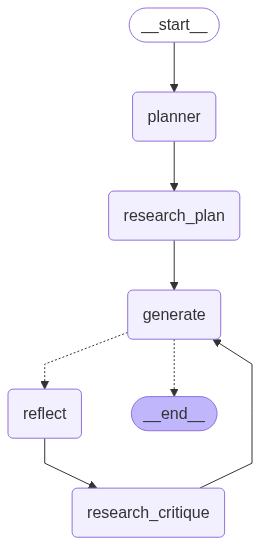

In [28]:
from IPython.display import Image

# Mermaidを使用して描画
Image(graph.get_graph().draw_mermaid_png())


## グラフの実行

エッセイライターをテストするために、graph.streamメソッドを使用しています。これにより、プロセスの各ステップをリアルタイムで確認できます。LangChainとLangSmithの違いについてのエッセイを書くよう依頼し、最大2回の修正を設定しています。

実行中は、各ノードからの出力が表示され、計画、研究、執筆、修正の段階を通じてエッセイがどのように進化するかを確認できます。

In [29]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream(
    {
        "task": "langchainとlangsmithの違いは何ですか",
        "max_revisions": 2,
        "revision_number": 1,
    },
    thread,
):
    print(s)

{'planner': {'plan': '以下に、「LangchainとLangsmithの違い」に関するエッセイのアウトラインを提案します：\n\nタイトル：LangchainとLangsmithの比較：AIアプリケーション開発における役割と特徴\n\nI. はじめに\n- AIアプリケーション開発における両ツールの重要性\n- 概要：Langchainとlangsmithの基本的な位置づけ\n\nII. Langchainの詳細\nA. 定義と主な機能\n- オープンソースのLLMアプリケーション開発フレームワーク\n- チェーンとエージェントの作成を支援\n\nB. 主な特徴\n- モジュラーな設計\n- 様々なLLMとの統合\n- プロンプトテンプレートの管理\n\nIII. Langsmithの詳細\nA. 定義と主な目的\n- LLMアプリケーションの開発、テスト、モニタリングツール\n- Langchainの公式デバッグ・観察プラットフォーム\n\nB. 主な機能\n- トレース機能\n- パフォーマンス分析\n- デバッグサポート\n\nIV. 両ツールの関係性\n- 相互補完的な関係\n- 開発ワークフローにおける連携\n\nV. 比較分析\nA. 技術的な違い\nB. ユースケース\nC. メリットとデメリット\n\nVI. 結論\n- AIアプリケーション開発における両ツールの重要性\n- 将来の展望\n\n注意点：\n- 技術的な詳細を明確に説明\n- 実際のコード例や具体的なシナリオを含める\n- 最新のAI開発トレンドとの関連性を強調\n\n推奨ソース：\n- 公式ドキュメンテーション\n- GitHubリポジトリ\n- 最新の技術記事'}}
{'research_plan': {'content': ['... 主な機能. 可視化（Observability） LLMは予測不能な結果を出すことがあるため、デバッグが難しいですが、LangSmithを使えばアプリのトレースを分析し', 'LangChainから使用することを考えると実験管理ツールは以下のLangSmith・Langfuseが良さそうです! それぞれのツールの強みは以下の通りです。 LangSmith.', 'LangSmithは、LangChain社が提供する大規模言語モ

## エッセイライターインターフェース

最後に、Gradioを使用したシンプルなGUIを使って、エッセイライターとの対話を簡単にしましょう。**重要な注意事項**: Amazon SageMaker Code Editor内でGradioを使用するには、アプリを`shared=True`モードで起動する必要があり、これによりパブリックリンクが作成されます。セキュリティの影響を理解するために、[セキュリティとファイルアクセス](https://www.gradio.app/guides/sharing-your-app#security-and-file-access)を確認してください。

このGUIでは、エッセイのトピックを入力し、エッセイを生成し、プロセスの各ステップの結果を確認できます。また、各ステップ後にプロセスを中断し、エッセイの現在の状態を表示し、エッセイを異なる方向に導きたい場合はトピックや計画を変更することもできます。

このGUIにより、エッセイライターを簡単に実験し、入力やプロセスの変更が最終出力にどのような影響を与えるかを確認できます。

これでAIエッセイライタープロジェクトは完了です！幅広いトピックについて研究、執筆、改良を行える複雑で多段階のAIエージェントが完成しました。このプロジェクトは、異なるAIとAPIサービスを組み合わせて強力で実用的なアプリケーションを作成する方法を実証しています。

In [32]:
#set magic variables to allow for a reload when changing code without restarting the kernel
%load_ext autoreload
%autoreload 2

import gradio as gr
from helper import ewriter, writer_gui

MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://3687430edda2cfa116.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
